# Check if the tidal elevation error has reached the equilibrium

In [1]:
%matplotlib inline
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from pylab import *
from math import atan2
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_JSL    = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_interior.nc'
file_stats  = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_static.nc'

In [3]:
JSL    = xr.open_dataset(file_JSL)
stat   = xr.open_dataset(file_stats)

In [4]:
depth  = stat['deptho']
geolat = stat['geolat']
geolon = stat['geolon']
yh, xh = stat.yh, stat.xh
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)

In [5]:
print(fac_dep.shape)

(1080, 1440)


In [6]:
ny, nx = JSL.yh.size, JSL.xh.size
elev_err_JSL = np.array([np.nan])
elev_JSL_3D  = np.full((149,ny,nx),np.nan)

In [71]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
pha_tpxo =  (tpxo.hp.isel({'nc':0}).transpose()-180) /180 *np.pi - 1.35
amp_tpxo =  tpxo.ha.isel({'nc':0}).transpose()
lon_tpxo =  tpgd.lon_z.transpose()
lat_tpxo =  tpgd.lat_z.transpose()
hz_tpxo  =  tpgd.hz.transpose()
ny, nx   =  tpgd.ny, tpgd.nx

In [72]:
ds_tpxo_data = xr.Dataset(data_vars={'pha_tpxo': (('ny','nx'), np.array(pha_tpxo)),
                                     'amp_tpxo': (('ny','nx'), np.array(amp_tpxo)),
                                     'hz_tpxo': (('ny','nx'), np.array(hz_tpxo))},
                          coords={'lon': (('ny', 'nx'), np.array(lon_tpxo)), 
                                  'lat': (('ny', 'nx'), np.array(lat_tpxo))})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat)),
                           "lon": (["yh","xh"], np.array(geolon))})
regridder = xe.Regridder(ds_tpxo_data, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_tpxo_mom6_grid = regridder(ds_tpxo_data)

In [9]:
days = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,30,31,31,30,31,30,31])
days_accum = np.cumsum(days)
print(days_accum)

[  0  31  59  90 120 151 181 212 243 273 304 334 365 396 424 455 485 516
 546 577 608 638 669 699 730]


In [73]:
exp_name = 'tides_025_SAL_JSL_x10'
for i in np.arange(11,12,1):
    print('Month %02d'%i)
    file = '/scratch/nm03/lxy581/mom6/archive/%s/output0%02d/ocean_interior.nc'%(exp_name,i)
    print(file)
    data = xr.open_dataset(file)
    elev_JSL_3D = np.array(data.e.isel({'time':np.arange(149),'zi':0}))
    t_12cyc = np.arange(149)
    nt_tpxo = t_12cyc.size
    omega_m2 = np.full((nt_tpxo,yh.size,xh.size),(2*np.pi/(12+5/12)))
    elev_tpxo = np.array(ds_tpxo_mom6_grid['amp_tpxo'])[None,:,:] * np.cos(omega_m2 * (t_12cyc[:,None,None]+days_accum[i]*24) - np.array(ds_tpxo_mom6_grid['pha_tpxo'])[None,:,:])

Month 11
/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_x10/output011/ocean_interior.nc


In [74]:
elev_JSL_3D = elev_JSL_3D * np.array(fac_lat)[None,:,:] * np.array(fac_dep)[None,:,:]
elev_tpxo   = elev_tpxo * np.array(fac_lat)[None,:,:] * np.array(fac_dep)[None,:,:]
elev_err    = np.nanmean(np.sqrt(np.nanmean((elev_JSL_3D - elev_tpxo)**2,axis=0))) *100
print(elev_err)

19.092494631238203


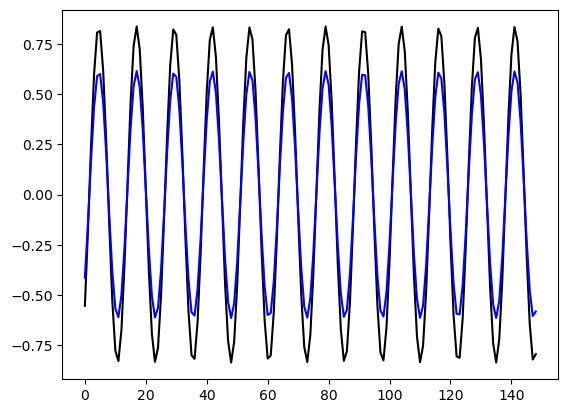

In [76]:
xind, yind = 1000, 100
plt.plot(elev_JSL_3D[:,yind,xind],'k')
plt.plot(elev_tpxo[:,yind,xind],'b')

In [77]:
def fitSine(tList,yList,freq=1/12.42):
   '''
       freq in cycle per hour
       tList in hours
   returns
       phase in radians
   '''
   b = matrix(yList).T
   rows = [ [cos(freq*2*pi*t), sin(freq*2*pi*t), 1] for t in tList]
   A = matrix(rows)
   (w,residuals,rank,sing_vals) = lstsq(A,b,rcond=None)
   phase = atan2(w[1,0],w[0,0])
   amplitude = norm([w[0,0],w[1,0]],2)
   bias = w[2,0]
   return (phase,amplitude,bias)

In [78]:
def get_amp_phase(elev_xr,xind,yind,time_len):
    time = np.arange(time_len)+days_accum[11]*24
    elev = np.array(elev_xr.isel({'xh':xind,'yh':yind,'zi':0,'time':np.arange(time_len)}))
    (phaseEst,amplitudeEst,biasEst) = fitSine(time,elev,freq=1/(12+5/12))
    return amplitudeEst,phaseEst/np.pi*180

In [79]:
amp, pha = get_amp_phase(data.e,xind,yind,149)
print(amp, pha/180*np.pi)

0.8374270814103922 -0.30817670290964866


In [80]:
amp_tpxo = np.array(ds_tpxo_mom6_grid['amp_tpxo'])[yind,xind]
pha_tpxo = np.array(ds_tpxo_mom6_grid['pha_tpxo'])[yind,xind]
print(amp_tpxo, pha_tpxo)

0.6153976731829126 -0.3039623139499519


In [81]:
pha_tpxo - pha/180*np.pi

0.00421438895969678

### Original model time series vs reconstructed time series

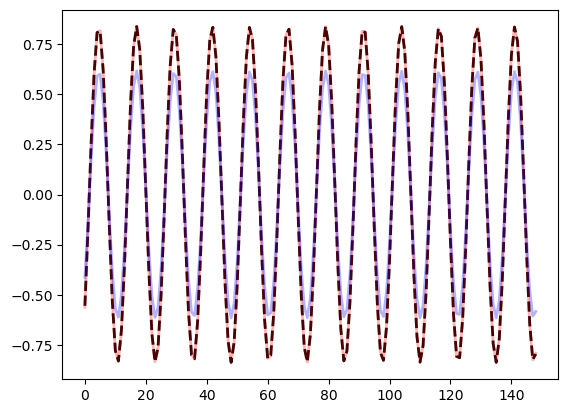

In [82]:
elev_recons_mom6 = np.array(amp * np.cos(omega_m2[0,0,0] * (t_12cyc+days_accum[11]*24) - pha/180*np.pi))
elev_recons_tpxo = np.array(amp_tpxo * np.cos(omega_m2[0,0,0] * (t_12cyc+days_accum[11]*24) - pha_tpxo ))

plt.plot(elev_JSL_3D[:,yind,xind],'k--',linewidth=2)
plt.plot(elev_recons_mom6,'r',linewidth=2,alpha=0.3)
plt.plot(elev_recons_tpxo,'b',linewidth=2,alpha=0.3)